In [1]:
# We needed to skip parsing the data first as I was limited with my poor computer RAM 
from adaptor_helper import SaveColorImageAsPng
import rosbag

import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

In [2]:
%load_ext autoreload
%autoreload 2

%reload_ext autoreload

# Using ROSBAG1 Parser

In [3]:
bag_file_path = '/home/jpdemir/c-hopper/data/edr_demo/predemo_drone_flying_and_taking_measurement_124115/oakd_ouster_vn100.bag'
bag = rosbag.Bag(bag_file_path, "r")

print(bag.get_type_and_topic_info().topics)

color_image_messages = bag.read_messages(topics=['/color/video/image'])
n_images = bag.get_message_count(topic_filters=["/color/video/image"])
image_downsample_rate = 1

color_camera_info_messages = bag.read_messages(topics=['/color/video/camera_info'])
_, camera_info, camera_info_t = next(color_camera_info_messages)
     
logging.info('Loaded the data!')
image_data = SaveColorImageAsPng(color_image_messages, int(n_images*1/6), image_downsample_rate)

logging.info('Finished data converting!')

INFO:root:Loaded the data!


{'/color/video/camera_info': TopicTuple(msg_type='sensor_msgs/CameraInfo', message_count=22151, connections=1, frequency=30.241641611328618), '/color/video/image': TopicTuple(msg_type='sensor_msgs/Image', message_count=6371, connections=1, frequency=18.97321370007396), '/points': TopicTuple(msg_type='sensor_msgs/PointCloud2', message_count=11225, connections=1, frequency=19.47329348267657), '/stereo/camera_info': TopicTuple(msg_type='sensor_msgs/CameraInfo', message_count=686, connections=1, frequency=0.8607539033817337), '/stereo/depth': TopicTuple(msg_type='sensor_msgs/Image', message_count=4863, connections=1, frequency=6.140641836495666), '/vn100_imu': TopicTuple(msg_type='sensor_msgs/Imu', message_count=6575, connections=1, frequency=8.010228821174195)}


100%|███████████████████████████████████████████████████████████████████████████████| 1061/1061 [01:14<00:00, 14.17it/s]


NameError: name 'logging' is not defined

In [3]:
camera_info

header: 
  seq: 0
  stamp: 
    secs: 1661258484
    nsecs: 369285391
  frame_id: "oak_rgb_camera_optical_frame"
height: 1080
width: 1920
distortion_model: "rational_polynomial"
d: [25.663156509399414, -218.04647827148438, 0.00047676885151304305, -0.00021448465122375637, 620.961181640625, 25.17365264892578, -214.8468475341797, 611.5280151367188]
k: [1549.841796875, 0.0, 935.3917846679688, 0.0, 1549.841796875, 552.15234375, 0.0, 0.0, 1.0]
r: [1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0]
p: [1549.841796875, 0.0, 935.3917846679688, 0.0, 0.0, 1549.841796875, 552.15234375, 0.0, 0.0, 0.0, 1.0, 0.0]
binning_x: 0
binning_y: 0
roi: 
  x_offset: 0
  y_offset: 0
  height: 0
  width: 0
  do_rectify: False

In [16]:
import cv2
import numpy as np
import os

image_save_dir = '/home/jpdemir/c-hopper/data/edr_demo/image_data'

# Change the current directory 
# to specified directory 
os.chdir(image_save_dir)

for i in range(len(image_data)):
    filename = 'rgb_' + str(i)+'.png'    
    image = image_data[i][1][:,:,::-1]
    cv2.imwrite(filename, image)

In [13]:
n_images

6371

In [14]:
len(image_data)

1062

# Using rosbag2 parser

https://ternaris.gitlab.io/rosbags/
- usage for rosbag2: https://gitlab.com/ternaris/rosbags/-/blob/master/tests/test_reader.py
- see https://gitlab.com/ternaris/rosbags/-/blob/master/tests/test_reader.py for usage

In [2]:
from rosbags.rosbag2 import Reader
from rosbags.serde import deserialize_cdr

import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

import os.path

In [3]:
img_topic_name = "/color/video/image"
camera_info_topic_name = '/color/video/camera_info'

# rosbag_path = "/media/luye/Gorgonzola/reifly/predemo_drone_flying_and_taking_measurement_124115/handheld_pod_bag"
# output_path = "/home/luye/Documents/Reifly/EDR-demo/predemo_drone_flying_and_taking_measurement_124115"

rosbag_path = "/media/luye/nvme-ssd-1TB/Datasets/EDR-demo/20220823_124115_drone_flying/handheld_pod_bag"
output_path = "/media/luye/nvme-ssd-1TB/Datasets/EDR-demo/20220823_124115_drone_flying/color_images"

# create reader instance and open for reading
i = 0
with Reader(rosbag_path) as reader:
    print("Connections available in bag:")
    print("\n\n".join([f"- {c}" for c in reader.connections]))
    
    topics_to_conn = {c.topic: c for c in reader.connections}
    img_conn = topics_to_conn[img_topic_name]
    # connections = [x for x in reader.connections if x.topic == '/magn']
    
    for connection, timestamp, rawdata in tqdm(reader.messages([img_conn]), total=img_conn.msgcount):
        msg = deserialize_cdr(rawdata, connection.msgtype)
        
        image_data = np.frombuffer(msg.data, np.uint8)
        image_data_reshaped = np.reshape(image_data, (msg.height, msg.width, 3))
        
        break
        
        # png likes bgr so we will leave it as it is
        # topic_clean = img_topic_name.replace('/', '_')
        # filename = os.path.join(output_path, topic_clean + f"_{i}.png")
        # cv2.imwrite(filename, image_data_reshaped)
        
        i += 1
        

Connections available in bag:
- Connection(id=1, topic='/points', msgtype='sensor_msgs/msg/PointCloud2', msgdef='', md5sum='', msgcount=2794, ext=ConnectionExtRosbag2(serialization_format='cdr', offered_qos_profiles=''), owner=<rosbags.rosbag2.reader.Reader object at 0x7f7e82265fa0>)

- Connection(id=2, topic='/color/video/image', msgtype='sensor_msgs/msg/Image', msgdef='', md5sum='', msgcount=2402, ext=ConnectionExtRosbag2(serialization_format='cdr', offered_qos_profiles=''), owner=<rosbags.rosbag2.reader.Reader object at 0x7f7e82265fa0>)

- Connection(id=3, topic='/stereo/depth', msgtype='sensor_msgs/msg/Image', msgdef='', md5sum='', msgcount=1853, ext=ConnectionExtRosbag2(serialization_format='cdr', offered_qos_profiles=''), owner=<rosbags.rosbag2.reader.Reader object at 0x7f7e82265fa0>)

- Connection(id=4, topic='/stereo/camera_info', msgtype='sensor_msgs/msg/CameraInfo', msgdef='', md5sum='', msgcount=257, ext=ConnectionExtRosbag2(serialization_format='cdr', offered_qos_profiles='

  0%|                                                  | 0/2402 [00:00<?, ?it/s]


In [16]:
msg.data.shape

(6220800,)

In [ ]:

image_data = np.frombuffer(msg.data, np.uint8)
image_data_bgr = np.reshape(image_data, (msg.height, msg.width, 3))
image_data_rgb = image_data_bgr[:, :, ::-1]
plt.imshow(image_data_rgb)

In [27]:
img_conn

Connection(id=3, topic='/color/video/image', msgtype='sensor_msgs/msg/Image', msgdef='', md5sum='', msgcount=6371, ext=ConnectionExtRosbag2(serialization_format='cdr', offered_qos_profiles=''), owner=<rosbags.rosbag2.reader.Reader object at 0x7f0fe5484940>)

In [28]:
img_conn.msgcount


6371

In [29]:
msg.header

std_msgs__msg__Header(stamp=builtin_interfaces__msg__Time(sec=1661258493, nanosec=838374494, __msgtype__='builtin_interfaces/msg/Time'), frame_id='oak_rgb_camera_optical_frame', __msgtype__='std_msgs/msg/Header')

In [32]:
msg.header.stamp.sec

1661258493

## Get Duration

In [5]:
# Get duration
from datetime import time, timedelta, datetime

timestamps = []
with Reader(rosbag_path) as reader:
    print(reader.duration)
    print(reader.start_time)
    print(reader.end_time)
    print(reader.message_count)

    
    topics_to_conn = {c.topic: c for c in reader.connections}
    img_conn = topics_to_conn[img_topic_name]
    
    gen1 = reader.messages([img_conn], start=reader.start_time)
    connection, timestamp, rawdata = next(gen1)
    stamp1 = timestamp
    msg1 = deserialize_cdr(rawdata, connection.msgtype)
    sec1 = msg1.header.stamp.sec
    
    gen2 = reader.messages([img_conn], start=reader.end_time- 10 * 1e9, stop=reader.end_time)
    connection, timestamp, rawdata = next(gen2)
    stamp2 = timestamp
    msg2 = deserialize_cdr(rawdata, connection.msgtype)
    sec2 = msg2.header.stamp.sec
    
        
        
dur_approx = timedelta(seconds=sec2-sec1)
print(f"Approximate duration of recording is: {dur_approx}")

dur_metadata = timedelta(seconds=int(reader.duration*1e-9))
print(f"Duration according to metadata is: {dur_approx}")

start_time = datetime.fromtimestamp(int(reader.start_time*1e-9))
print(f"Recording start time is {start_time}")

333090819777
1661258483009571368
1661258816100391145
18342
Approximate duration of recording is: 0:05:20
Duration according to metadata is: 0:05:20
Recording start time is 2022-08-23 13:41:23


In [7]:
reader.start_time
stamp1

1661258485259207400

## Plot samples

Save sample image every 30 sec

In [51]:
timestamps_header = []
timestamps_message = []
images = []

sample_period_sec = 5
step = int(img_conn.msgcount / dur_metadata.total_seconds() * sample_period_sec)
print(f"Step size is {step} images for {sample_period_sec} seconds.")

def msg_time_to_ns(msg_time) -> int:
    return msg_time.sec * int(1e9) + msg_time.nanosec

i = 0
with Reader(rosbag_path) as reader:
    
    topics_to_conn = {c.topic: c for c in reader.connections}
    img_conn = topics_to_conn[img_topic_name]
    # connections = [x for x in reader.connections if x.topic == '/magn']
    
    for connection, timestamp_subscriber, rawdata in tqdm(reader.messages([img_conn]), total=img_conn.msgcount):
        msg = deserialize_cdr(rawdata, connection.msgtype)
        timestamp_publisher = msg_time_to_ns(msg.header.stamp)
        timestamps_header.append(timestamp_publisher)
        timestamps_message.append(timestamp_subscriber)
            
        if (i % step) == 0:
            image_data = np.frombuffer(msg.data, np.uint8)
            image_data_bgr = np.reshape(image_data, (msg.height, msg.width, 3))
            images.append(image_data_bgr)
            
        i += 1
        # print(".", end='')

Step size is 36 images for 5 seconds.


100%|███████████████████████████████████████| 2402/2402 [00:29<00:00, 81.95it/s]


In [9]:
len(images)

67

In [ ]:
for i, img in enumerate(images):
    print(f"Image header timestamp: {timestamps_header[i]}")
    print(f"Message timestamps (ns): {timestamps_message[i]}")
    plt.figure()
    plt.imshow(img[:, :, ::-1])
    plt.suptitle(f"IMG {i} Timestamps from message: {timestamps_message[i]} ns; header: {timestamps_header[i].sec} s {timestamps_header[i].nanosec} ns")

## Video Sample Rate

In [48]:
avg_rate_hz = float(len(timestamps_header)) / dur_metadata.total_seconds()
avg_rate_hz

7.213213213213213

In [52]:
# Use publisher timestamps as image timestamps
img_timestamps_ns = timestamps_header

sample_times = np.array(img_timestamps_ns)
sample_times_sec = (sample_times - sample_times[0]) * 1e-9
sample_times_sec

array([0.00000000e+00, 1.65554331e-01, 3.31866984e-01, ...,
       3.30157667e+02, 3.30257605e+02, 3.30357556e+02])

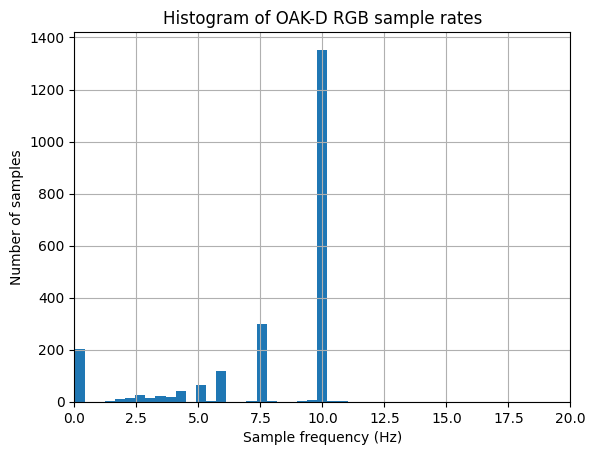

In [53]:
sample_intervals_sec = np.diff(sample_times_sec)
sample_freqs_sec = 1 / sample_intervals_sec

# bins = 50 # auto, num bins
bins = np.linspace(0, 20, 50) # manual bins
n, bins, patches = plt.hist(sample_freqs_sec, bins=bins)
plt.xlim(0, 20)

plt.xlabel('Sample frequency (Hz)')
plt.ylabel('Number of samples')  # Probability if density=True
plt.title('Histogram of OAK-D RGB sample rates')
plt.xlim(0, 20)
# plt.ylim(0, 0.03)
plt.grid(True)

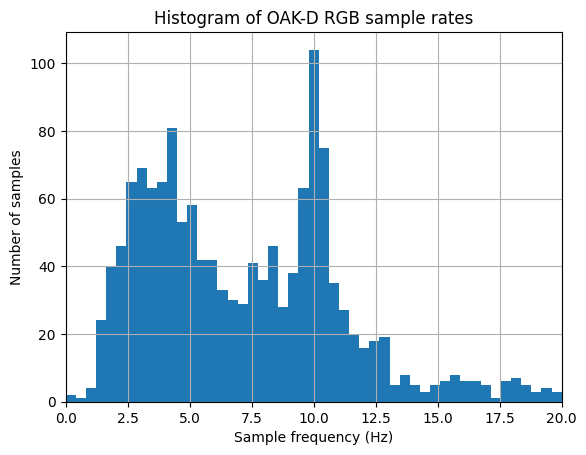

In [54]:
# Check rosbag writer timestamps - should be different
sample_times_subscriber = np.array(timestamps_message)
sample_times_subscriber_sec = (sample_times_subscriber - sample_times_subscriber[0]) * 1e-9

sample_intervals_subscriber_sec = np.diff(sample_times_subscriber_sec)
sample_freqs_subscriber_sec = 1 / sample_intervals_subscriber_sec

# bins = 50 # auto, num bins
bins = np.linspace(0, 20, 50) # manual bins
n, bins, patches = plt.hist(sample_freqs_subscriber_sec, bins=bins)
plt.xlim(0, 20)

plt.xlabel('Sample frequency (Hz)')
plt.ylabel('Number of samples')  # Probability if density=True
plt.title('Histogram of OAK-D RGB sample rates')
plt.xlim(0, 20)
# plt.ylim(0, 0.03)
plt.grid(True)

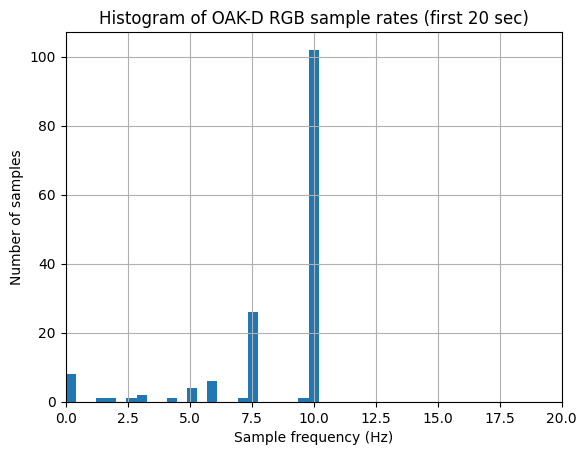

In [56]:
# To investigate whether the rate is due to heat throttling,
# let's plot only the initial values when the device just started the recording

initial_secs = 20
initial_sample_times = sample_times_sec[sample_times_sec < initial_secs]
sample_intervals_sec = np.diff(initial_sample_times)
sample_freqs_sec = 1 / sample_intervals_sec

# bins = 50 # auto, num bins
bins = np.linspace(0, 20, 50) # manual bins
n, bins, patches = plt.hist(sample_freqs_sec, bins=bins)
plt.xlim(0, 20)

plt.xlabel('Sample frequency (Hz)')
plt.ylabel('Number of samples')  # Probability if density=True
plt.title(f'Histogram of OAK-D RGB sample rates (first {initial_secs} sec)')
plt.xlim(0, 20)
# plt.ylim(0, 0.03)
plt.grid(True)

## Save time range to PNG

- dataset `/media/luye/nvme-ssd-1T/Datasets/EDR-demo/20220823_124115_drone_flying`
    - drone + different camera angles: `13:42:00 - 13:42:09`
    - t1 = `1661258520.068707816` seconds UNIX time
    - t2 = `1661258530.134524104` seconds UNIX time


In [14]:
# create reader instance and open for reading

# Message timestamps for snipping

# ts1 = 1661258654881419624
# ts2 = 1661258685611132072

# ts1 = reader.start_time
# ts2 = reader.end_time

ts1 = 1661258520068707816
ts2 = 1661258530134524104
output_path = "/media/luye/nvme-ssd-1T/Datasets/EDR-demo/20220823_124115_drone_flying/measurement_1_images"

# sample_period_sec = 5
# step = int(img_conn.msgcount / dur_metadata.total_seconds() * sample_period_sec)
# print(f"Step size is {step} images for {sample_period_sec} seconds.")


with Reader(rosbag_path) as reader:
   
    topics_to_conn = {c.topic: c for c in reader.connections}
    img_conn = topics_to_conn[img_topic_name]
    
    gen = reader.messages([img_conn], start=ts1, stop=ts2)
    total = int(img_conn.msgcount * (ts2 - ts1) / reader.duration)
    
    i = 0
    
    for connection, timestamp, rawdata in tqdm(gen, total=total):
        msg = deserialize_cdr(rawdata, connection.msgtype)
        
        image_data = np.frombuffer(msg.data, np.uint8)
        image_data_reshaped = np.reshape(image_data, (msg.height, msg.width, 3))
        
        
        # png likes bgr so we will leave it as it is
        topic_clean = img_topic_name.strip('/').replace('/', '_')
        filename = os.path.join(output_path, topic_clean + f"_t{timestamp}.png")
        cv2.imwrite(filename, image_data_reshaped)
        
        i += 1
        
    print(f"Wrote images to {output_path}")

 92%|██████████████████████████████████████████████████████████████████████████████████████████████▍        | 66/72 [00:16<00:01,  4.06it/s]

Wrote images to /media/luye/nvme-ssd-1T/Datasets/EDR-demo/20220823_124115_drone_flying/measurement_1_images


In [15]:
len('1661258530134524104')

19

## Video Conversion

See http://wiki.ros.org/rosbag/Tutorials/Exporting%20image%20and%20video%20data#Converting_jpegs_into_an_OGG_Theora_Video

Could also be done using GStreamer

```sh
ffmpeg -framerate 7.21 -i frame%04d.jpg -c:v libx264 -profile:v high -crf 20 -pix_fmt yuv420p output.mp4
```

If you want to chage the output framerate by interpolating/dropping images: do

```sh
ffmpeg -framerate <input rate> -i input_%03d.png -r <output_rate> output.mp4
```

## IMU data extraction

IMU connection: `Connection(id=6, topic='/vn100_imu', msgtype='sensor_msgs/msg/Imu', msgdef='', md5sum='', msgcount=2551, ext=ConnectionExtRosbag2(serialization_format='cdr', offered_qos_profiles=''), owner=<rosbags.rosbag2.reader.Reader object at 0x7f7e8cad3220>)`

In [36]:
rosbag_path = "/media/luye/nvme-ssd-1TB/Datasets/EDR-demo/20220823_124115_drone_flying/handheld_pod_bag"
output_path = "/media/luye/nvme-ssd-1TB/Datasets/EDR-demo/20220823_124115_drone_flying/measurement_1_images"

ts1 = 1661258520068707816
ts2 = 1661258530134524104
use_interval = False

# sample_period_sec = 5
# step = int(img_conn.msgcount / dur_metadata.total_seconds() * sample_period_sec)
# print(f"Step size is {step} images for {sample_period_sec} seconds.")

IMU_TOPIC = "/vn100_imu"

timestamps_subscriber = [] # timestamps of the suscriber to imu messages (rosbag writer)


imu_data = []
with Reader(rosbag_path) as reader:
    
    if not use_interval:
        ts1, ts2 = reader.start_time, reader.end_time
   
    topics_to_conn = {c.topic: c for c in reader.connections}
    imu_conn = topics_to_conn[IMU_TOPIC]
    
    gen = reader.messages([imu_conn], start=ts1, stop=ts2)
    total = int(imu_conn.msgcount * (ts2 - ts1) / reader.duration)
    
    i = 0
    
    for connection, timestamp, rawdata in tqdm(gen, total=total):
        imu_msg = deserialize_cdr(rawdata, connection.msgtype)
        
        # break
        timestamps_subscriber.append(timestamp)
        timestamp_publisher = msg_time_to_ns(imu_msg.header.stamp)
        imu_data.append([timestamp_publisher, imu_msg.orientation, imu_msg.orientation_covariance, imu_msg.angular_velocity, imu_msg.linear_acceleration])
        
        i += 1
        

100%|████████████████████████████████████| 2551/2551 [00:00<00:00, 20870.60it/s]


In [37]:
imu_msg

sensor_msgs__msg__Imu(header=std_msgs__msg__Header(stamp=builtin_interfaces__msg__Time(sec=0, nanosec=0, __msgtype__='builtin_interfaces/msg/Time'), frame_id='', __msgtype__='std_msgs/msg/Header'), orientation=geometry_msgs__msg__Quaternion(x=-0.013838458806276321, y=-0.01612642966210842, z=-0.23991312086582184, w=-0.9705618023872375, __msgtype__='geometry_msgs/msg/Quaternion'), orientation_covariance=array([1.01319720e-06, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       9.97296965e-07, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       6.09688263e-07]), angular_velocity=geometry_msgs__msg__Vector3(x=-0.008427143096923828, y=-0.014842948876321316, z=-0.00044051557779312134, __msgtype__='geometry_msgs/msg/Vector3'), angular_velocity_covariance=array([0., 0., 0., 0., 0., 0., 0., 0., 0.]), linear_acceleration=geometry_msgs__msg__Vector3(x=0.49088287353515625, y=0.020514845848083496, z=-9.33029556274414, __msgtype__='geometry_msgs/msg/Vector3'), linear_acceleration_covariance=ar

In [39]:
print(imu_msg.header.stamp)
print(timestamp_publisher)
print(imu_msg)

builtin_interfaces__msg__Time(sec=0, nanosec=0, __msgtype__='builtin_interfaces/msg/Time')
18154575
sensor_msgs__msg__Imu(header=std_msgs__msg__Header(stamp=builtin_interfaces__msg__Time(sec=0, nanosec=0, __msgtype__='builtin_interfaces/msg/Time'), frame_id='', __msgtype__='std_msgs/msg/Header'), orientation=geometry_msgs__msg__Quaternion(x=-0.013838458806276321, y=-0.01612642966210842, z=-0.23991312086582184, w=-0.9705618023872375, __msgtype__='geometry_msgs/msg/Quaternion'), orientation_covariance=array([1.01319720e-06, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       9.97296965e-07, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       6.09688263e-07]), angular_velocity=geometry_msgs__msg__Vector3(x=-0.008427143096923828, y=-0.014842948876321316, z=-0.00044051557779312134, __msgtype__='geometry_msgs/msg/Vector3'), angular_velocity_covariance=array([0., 0., 0., 0., 0., 0., 0., 0., 0.]), linear_acceleration=geometry_msgs__msg__Vector3(x=0.49088287353515625, y=0.0205148458480834

In [12]:
print(imu_msg.orientation)
print(imu_msg.orientation_covariance)
print(imu_msg.angular_velocity)
print(imu_msg.linear_acceleration)

geometry_msgs__msg__Quaternion(x=-0.19707486033439636, y=-0.000939575198572129, z=0.9633657336235046, w=-0.18189889192581177, __msgtype__='geometry_msgs/msg/Quaternion')
[5.34066604e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00
 5.03712813e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.60964292e-03]
geometry_msgs__msg__Vector3(x=0.1584160476922989, y=-0.0031754032243043184, z=-0.1178215742111206, __msgtype__='geometry_msgs/msg/Vector3')
geometry_msgs__msg__Vector3(x=3.2481846809387207, y=-0.7412334680557251, z=-8.755314826965332, __msgtype__='geometry_msgs/msg/Vector3')


In [16]:
imu_msg.angular_velocity

geometry_msgs__msg__Vector3(x=0.1584160476922989, y=-0.0031754032243043184, z=-0.1178215742111206, __msgtype__='geometry_msgs/msg/Vector3')

### IMU Sample Rate

NOTE: it was found that the publisher does not put the time into msg.header.stamp.

Therefore we cannot recover the sample times. Our only alternative is to construct
them manually by dividing the duration by the number of samples.

In [40]:
sample_times = np.array([data[0] for data in imu_data])
sample_times_sec = (sample_times - sample_times[0]) * 1e-9
sample_times_sec

dur_sec = int((ts2 - ts1) * 1e-9)
artificial_sample_times_sec = np.linspace(0, dur_sec, len(imu_data))
artificial_sample_times_sec

array([0.00000000e+00, 1.30588235e-01, 2.61176471e-01, ...,
       3.32738824e+02, 3.32869412e+02, 3.33000000e+02])

In [46]:
# avg_rate_hz = 1 / np.diff(artificial_sample_times_sec)[0]
avg_rate_hz = len(imu_data) / dur_sec
avg_rate_hz

7.66066066066066

/tmp/ipykernel_14490/3924288075.py:2: RuntimeWarning: divide by zero encountered in divide
  sample_freqs_sec = 1 / sample_intervals_sec


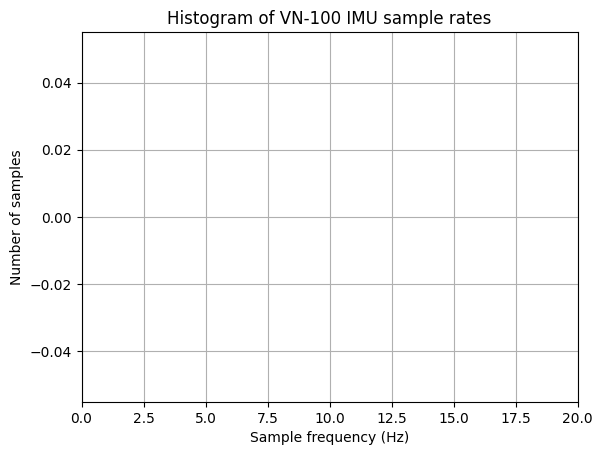

In [31]:
sample_intervals_sec = np.diff(sample_times_sec)
sample_freqs_sec = 1 / sample_intervals_sec

# bins = 50 # auto, num bins
bins = np.linspace(0, 20, 50) # manual bins
n, bins, patches = plt.hist(sample_freqs_sec, bins=bins)
plt.xlim(0, 20)

plt.xlabel('Sample frequency (Hz)')
plt.ylabel('Number of samples')  # Probability if density=True
plt.title('Histogram of VN-100 IMU sample rates')
plt.xlim(0, 20)
# plt.ylim(0, 0.03)
plt.grid(True)